### Mô hình ngôn ngữ và ứng dụng cho kiểm lỗi chính tả

Yêu cầu: 
a)	Xây dựng mô hình ngôn ngữ như là bài toán phân loại sử dụng CNN và LSTM.
b)	Làm sao giải quyết vấn đề sparse data (dữ liệu thưa) trong mô hình này? 


#### Đọc file input lấy max = 1000

In [25]:
# đọc file
filename='tedtalk.txt'
with open(filename, 'r', encoding='utf-8')  as file:
    lines=file.readlines()

max_lines = 1000   
lines=lines[:max_lines]
# drop \n:
lines=[line.strip() for line in lines]
print(len(lines))
print(lines[:5])

1000
["Here are two reasons companies fail: they only do more of the same, or they only do what's new", 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation', 'Both are necessary, but it can be too much of a good thing', 'Consider Facit', "I'm actually old enough to remember them"]


#### tokenize, thêm ký hiệu '\<s\>' đầu câu, '\</s\>' cuối câu

In [26]:
# add <s> and </s> to each line
import nltk
from nltk.tokenize import word_tokenize
sentences=[]
all_tokens_count=0
for line in lines:
    tokens=word_tokenize(line)
    tokens.insert(0,'<s>')
    tokens.append('</s>')
    sentences.append(tokens)
    all_tokens_count+=len(tokens)

print('all_tokens_count:', all_tokens_count)
print('sentences:', len(sentences))
print(sentences[:5])

all_tokens_count: 19965
sentences: 1000
[['<s>', 'Here', 'are', 'two', 'reasons', 'companies', 'fail', ':', 'they', 'only', 'do', 'more', 'of', 'the', 'same', ',', 'or', 'they', 'only', 'do', 'what', "'s", 'new', '</s>'], ['<s>', 'To', 'me', 'the', 'real', ',', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', ':', 'exploration', 'and', 'exploitation', '</s>'], ['<s>', 'Both', 'are', 'necessary', ',', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing', '</s>'], ['<s>', 'Consider', 'Facit', '</s>'], ['<s>', 'I', "'m", 'actually', 'old', 'enough', 'to', 'remember', 'them', '</s>']]


#### Tạo dữ liệu training w(i-k)...w(i-1) dự đoán w(i)

In [27]:

import random 
def get_instances(sent):
    samples=[]
    for i in range(1, len(sent)-1):
        samples.append((sent[i], sent[i-1], sent[i+1]))
    return samples

data=[]
for sent in sentences:
    data.extend(get_instances(sent))
print(len(data))

# test thử hàm get_instances

samples = get_instances(sentences[0])
for instance in samples:
    print(instance)

17965
('Here', '<s>', 'are')
('are', 'Here', 'two')
('two', 'are', 'reasons')
('reasons', 'two', 'companies')
('companies', 'reasons', 'fail')
('fail', 'companies', ':')
(':', 'fail', 'they')
('they', ':', 'only')
('only', 'they', 'do')
('do', 'only', 'more')
('more', 'do', 'of')
('of', 'more', 'the')
('the', 'of', 'same')
('same', 'the', ',')
(',', 'same', 'or')
('or', ',', 'they')
('they', 'or', 'only')
('only', 'they', 'do')
('do', 'only', 'what')
('what', 'do', "'s")
("'s", 'what', 'new')
('new', "'s", '</s>')


#### hiển thị bản đồ histogram của data

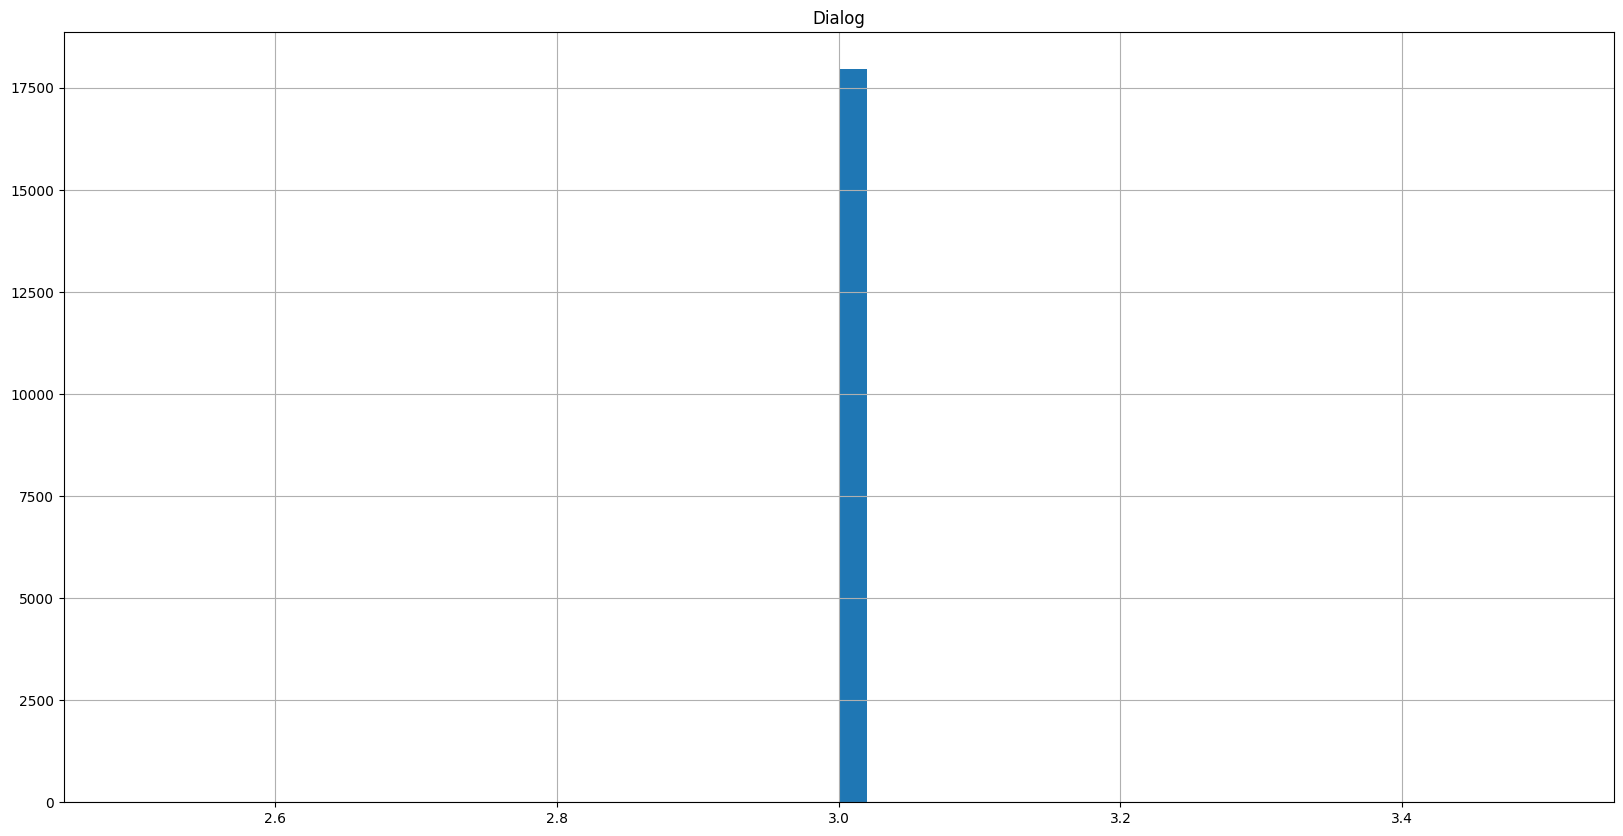

In [28]:
# bản đồ histogram của data 
import pandas as pd
import matplotlib.pyplot as plt
alllength = [len(x) for x in data]
plt.rcParams['figure.figsize'] = (20, 10)
length_df = pd.DataFrame({'Dialog':alllength})
length_df.hist(bins=50)
plt.show()

In [45]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.metrics import confusion_matrix,f1_score,classification_report

In [46]:
# lấy max của độ dài để dự đoán từ tiếp theo
max_sequence_len=20

data1 = [' '.join(x) for x in data]

tokenizer = Tokenizer(filters='') 
tokenizer.fit_on_texts(data1)
#print(tokenizer.word_index)
vocab_size = len(tokenizer.word_index) + 1
print('vocab size:',vocab_size)

vocab size: 3097


In [57]:
# viết code chuẩn hoá input
data_sequence = tokenizer.texts_to_sequences(data1)
y_data= [x[0] for x in data_sequence]

X_data = pad_sequences(data_sequence, maxlen=max_sequence_len, padding='pre')
#END YOUR CODE

print(X_data[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  93
    7  24]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  24
   93 120]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 120
   24 616]]


In [48]:
print(X_data[:3])
print(y_data[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  93
    7  24]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  24
   93 120]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 120
   24 616]]
[93, 24, 120]


In [58]:
y_data = keras.utils.to_categorical(y_data,num_classes=vocab_size)
print(y_data.shape)
print(y_data[0])

(17965, 3097)
[0. 0. 0. ... 0. 0. 0.]


In [50]:
print(X_data.shape)
print(y_data.shape)

(17965, 20)
(17965, 3097)


In [59]:
def get_params():
    return {'max_seq_len': max_sequence_len, 'vocab_size':vocab_size }

params = get_params()

inputs = keras.layers.Input(shape=(params['max_seq_len'],))
embedding = keras.layers.Embedding(params['vocab_size'], 200, input_length=params['max_seq_len'])(inputs)
print(inputs.shape)
print(embedding.shape)

(None, 20)
(None, 20, 200)


In [60]:
# building CNN model

conv1 = keras.layers.Conv1D(128, 3, activation='relu')(embedding)
pool1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
conv2 = keras.layers.Conv1D(64, 3, activation='relu')(pool1)
pool2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
flat = keras.layers.Flatten()(pool2)
dense = keras.layers.Dense(128, activation='relu')(flat)
output = keras.layers.Dense(params['vocab_size'], activation='softmax')(dense)

model = keras.models.Model(inputs=inputs, outputs=output)

In [53]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 20, 200)           619400    
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 128)           76928     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 128)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 64)             24640     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3, 64)            0         
 1D)                                                       

In [54]:
type(y_data),len(y_data)

(numpy.ndarray, 17965)

In [62]:
# Ensure y_data is a numpy array
y_data = np.array(y_data)


# Print shapes to verify
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)

# Fit the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_data, y_data, batch_size=100, epochs=3)

X_data shape: (17965, 20)
y_data shape: (17965, 3097)
Epoch 1/3
180/180 [==============================] - 4s 17ms/step - loss: 6.0292 - accuracy: 0.0622
Epoch 2/3
180/180 [==============================] - 3s 16ms/step - loss: 4.1108 - accuracy: 0.3103
Epoch 3/3
180/180 [==============================] - 3s 17ms/step - loss: 2.9609 - accuracy: 0.5239


In [63]:
inputs2 = keras.layers.Input(shape=(params['max_seq_len'],))
embedding2 = keras.layers.Embedding(params['vocab_size'], 200, input_length=params['max_seq_len'])(inputs2)

#BEGIN YOUR CODE
# building RNN model
lstm1 = keras.layers.LSTM(128, return_sequences=True)(embedding2)
lstm2 = keras.layers.LSTM(64)(lstm1)
dense2 = keras.layers.Dense(params['vocab_size'], activation='softmax')(lstm2)

#END YOUR CODE

model2 = keras.Model(inputs=inputs2, outputs=dense2)
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 20, 200)           619400    
                                                                 
 lstm (LSTM)                 (None, 20, 128)           168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 3097)              201305    
                                                                 
Total params: 1,038,561
Trainable params: 1,038,561
Non-trainable params: 0
_________________________________________________________________


In [65]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_data,y_data,batch_size=100, epochs=3)   

Epoch 1/3
180/180 [==============================] - 9s 39ms/step - loss: 6.6445 - accuracy: 0.0572
Epoch 2/3
180/180 [==============================] - 7s 39ms/step - loss: 6.2385 - accuracy: 0.0577
Epoch 3/3
180/180 [==============================] - 7s 39ms/step - loss: 5.8806 - accuracy: 0.0577
